In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchsummary import summary
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import torch
# Speeds up convolutions by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Load the data path to images
# Rmb to mount your Gdrive
IMG_DIR = '/content/drive/MyDrive/fish_are_mans_friend/data/train'

# Batch Size
BATCH_SIZE = 64

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}

# We will assume that all images are of .jpg and .png extensions

In [ ]:
# Split our training dataset to train and valid
def perform_train_valid_split(train_dataset,test_size=0.3,shuffle=True):
    train, valid = train_test_split(
                                            np.arange(len(train_dataset.targets)),
                                            test_size=test_size,
                                            shuffle=shuffle
                                  )

    return train, valid

In [ ]:
# For using our pre-trained model AlexNet, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]
        )

# Load the training and validation dataset
try:  
  dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate.
valid_split = 0.2
data_size = len(dataset)
valid_size =  int(data_size * valid_split)
train_size =  data_size - valid_size

train_dataset, valid_dataset = random_split(dataset, [train_size,valid_size],generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: /content/drive/MyDrive/fish_are_mans_friend/data/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


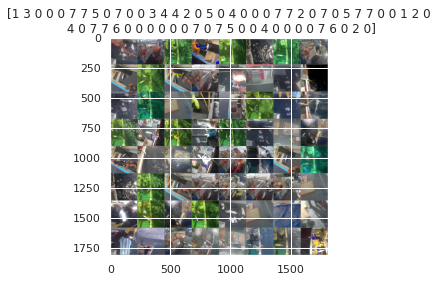

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrows=20)
imshow(out,title=classes.numpy())

In [ ]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = models.alexnet(pretrained=True)
print(model_ft)

cuda


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def weight_builder(label_map,data_size):
  weights = []
  for value in label_map.values():
    weights.append(len(glob.glob(f"{IMG_DIR}/{value}"))/data_size)
  return weights

In [ ]:
  # Freeze model parameters because they were trained already
for param in model_ft.parameters():
    param.requires_grad = False

# Change the final layer of AlexNet Model for Transfer Learning
# Here the size of each output sample is set to 8
  fc_inputs = model_ft.classifier[-3].out_features
  model_ft.classifier[-1] = nn.Sequential(
      nn.Linear(fc_inputs, 256),
      nn.ReLU(),
      nn.Dropout(0.4),
      nn.Linear(256, len(CLASSES))
  )
model_ft = model_ft.to(device)
# Create weights to handle class imbalance
weights = weight_builder(label_map,data_size)
# added weights to crossentropyloss for class imbalance
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
# We will use ADAM as our opitimiser
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
import copy
import time
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1086 Acc: 0.6152
val Loss: 0.7046 Acc: 0.7669

Epoch 1/24
----------
train Loss: 0.6634 Acc: 0.7581
val Loss: 0.5354 Acc: 0.8172

Epoch 2/24
----------
train Loss: 0.5283 Acc: 0.8150
val Loss: 0.4743 Acc: 0.8424

Epoch 3/24
----------
train Loss: 0.4580 Acc: 0.8408
val Loss: 0.4213 Acc: 0.8702

Epoch 4/24
----------
train Loss: 0.3916 Acc: 0.8617
val Loss: 0.4142 Acc: 0.8795

Epoch 5/24
----------
train Loss: 0.3636 Acc: 0.8743
val Loss: 0.3617 Acc: 0.8940

Epoch 6/24
----------
train Loss: 0.3090 Acc: 0.8901
val Loss: 0.3656 Acc: 0.8901

Epoch 7/24
----------
train Loss: 0.2671 Acc: 0.9007
val Loss: 0.3560 Acc: 0.9033

Epoch 8/24
----------
train Loss: 0.2274 Acc: 0.9209
val Loss: 0.3492 Acc: 0.9099

Epoch 9/24
----------
train Loss: 0.2142 Acc: 0.9295
val Loss: 0.3372 Acc: 0.9086

Epoch 10/24
----------
train Loss: 0.2098 Acc: 0.9246
val Loss: 0.3372 Acc: 0.9086

Epoch 11/24
----------
train Loss: 0.2006 Acc: 0.9295
val Loss: 0.3308 Acc: 0.9099

Ep

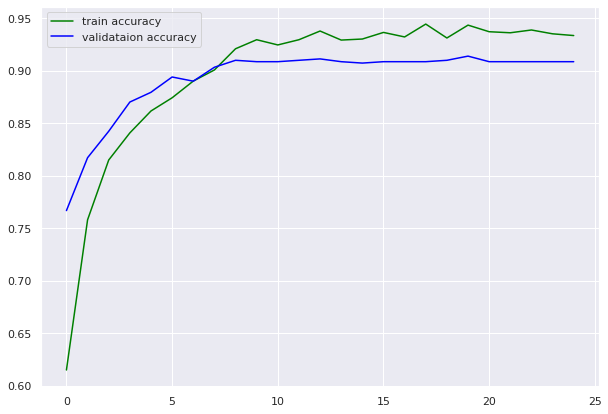

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
# plt.savefig('../images/train_val_accuracy.png')
plt.show()

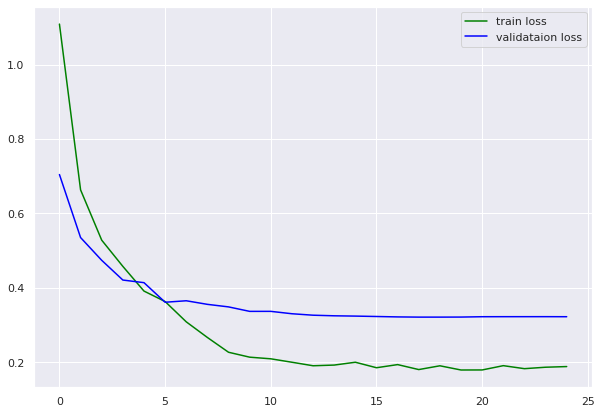

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validataion loss')
plt.legend()
# plt.savefig('/content/drive/MyDrive/fish_are_mans_friend/qy_images/train_val_loss.png')
plt.show()

In [ ]:
torch.save(model_ft,'Alexnet_v1_25_0.914.pt')

In [ ]:
# LIME MODEL INTERPRETATION

# take a test image

# get prediction for an image
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

# Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy())) 

# we need to provide two things: 
# (1) original image as numpy array 
# (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output.

# For Pytorch, first we need to define two separate transforms: 
# (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

# define classification function that Lime needs
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

# run it on test image
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()



In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# create explanation for this prediciton
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

# use mask on image and see the areas that are encouraging the top prediction.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

In [ ]:
# turn on areas that contributes against the top prediction.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)